# Sentiment Analysis Deep Learning

## 🔧 Configuration et Imports

Commençons par importer toutes les bibliothèques nécessaires et configurer notre environnement NLP.

In [ ]:
import logging
import sqlite3
import json
import re
import random
from datetime import datetime
from collections import Counter
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer, TFRobertaModel
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings

warnings.filterwarnings('ignore')

warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )
logger = logging.getLogger(__name__)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(42)    

/Users/cedric/Projects/Alyra/tf/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 🖥️ Configuration GPU pour NLP

Les modèles de NLP comme BERTweet consomment beaucoup de mémoire. Configurons le GPU prudemment :

In [2]:
# Configuration TensorFlow
tf.config.run_functions_eagerly(True)  # Pour le debugging
gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)
print(f"🚀 TensorFlow version: {tf.__version__}")
print(f"💻 GPU disponible: {'✅ Oui' if len(gpus) > 0 else '❌ Non (CPU utilisé)'}")

# Configuration GPU spéciale pour les modèles NLP volumineux
if gpus:
    try:
        # Utiliser seulement le premier GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Croissance mémoire progressive (important pour les transformers)
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ Configuration GPU réussie: {gpus[0].name}")
        print("🧠 Mémoire GPU configurée en croissance progressive")
    except RuntimeError as e:
        print(f"⚠️ Erreur configuration GPU: {e}")
else:
    print("🔧 Utilisation du CPU - Les modèles NLP fonctionnent aussi (plus lentement)")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🚀 TensorFlow version: 2.19.0
💻 GPU disponible: ✅ Oui
✅ Configuration GPU réussie: /physical_device:GPU:0
🧠 Mémoire GPU configurée en croissance progressive


## ⚙️ Configuration globale

In [ ]:
config = {
        "model_name": "vinai/bertweet-base",
        "max_length": 64,
        "learning_rate": 2e-5,
        "warmup_steps": 500,
        "num_samples_train": 5000,
        "num_samples_val": 1000,
        "layer_1": 256,
        "activation_1": "gelu",
        "dropout_1": random.uniform(0.01, 0.80),
        "layer_2": 1,
        "activation_2": "sigmoid",
        "num_classes": 1,
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "num_epochs": 6,
        "batch_size": 32
    }

# 📊 Paramètres spécifiques au fine-tuning NLP
MODEL_NAME = config['model_name']
BATCH_SIZE = config['batch_size']            # Taille du batch
MAX_LENGTH = config['max_length']            # Longueur max des séquences (tokens)
EPOCHS = config['num_epochs']                 # Nombre d'époques
LEARNING_RATE = config['learning_rate']       # Learning rate typique pour BERT/DistilBERT/RoBERTa 2e-5 sinon 1e-3, 1e-5
NUM_CLASSES = config['num_classes']            # Binary classification with sigmoid (NEGATIVE/POSITIVE)
WARMUP_STEPS = config['warmup_steps']         # Nombre de pas de warmup

NUM_SAMPLES_TRAIN = config['num_samples_train']   # Limitation pour l'exemple pédagogique
NUM_SAMPLES_VAL = config['num_samples_val']     # Échantillon de validation

print("📋 Configuration d'entraînement NLP:")
print(f"   • Taille de batch: {BATCH_SIZE}")
print(f"   • Longueur max: {MAX_LENGTH} tokens")
print(f"   • Nombre d'époques: {EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Échantillons train/val: {NUM_SAMPLES_TRAIN}/{NUM_SAMPLES_VAL}")


📋 Configuration d'entraînement NLP:
   • Taille de batch: 32
   • Longueur max: 64 tokens
   • Nombre d'époques: 6
   • Learning rate: 2e-05
   • Échantillons train/val: 5000/1000


## 🔤 Tokenisation avec BERTweet

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False, normalization=True)

print(f"✅ Tokenizer {MODEL_NAME} chargé avec succès !")
print(f"📊 Taille du vocabulaire: {tokenizer.vocab_size:,} tokens")

# Informations sur les tokens spéciaux
print(f"\n🎯 Tokens spéciaux:")
print(f"   🏁 CLS (début): '{tokenizer.cls_token}' (ID: {tokenizer.cls_token_id})")
print(f"   🔚 SEP (fin): '{tokenizer.sep_token}' (ID: {tokenizer.sep_token_id})")
print(f"   📝 PAD (padding): '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")
print(f"   ❓ UNK (inconnu): '{tokenizer.unk_token}' (ID: {tokenizer.unk_token_id})")

✅ Tokenizer vinai/bertweet-base chargé avec succès !
📊 Taille du vocabulaire: 64,000 tokens

🎯 Tokens spéciaux:
   🏁 CLS (début): '<s>' (ID: 0)
   🔚 SEP (fin): '</s>' (ID: 2)
   📝 PAD (padding): '<pad>' (ID: 1)
   ❓ UNK (inconnu): '<unk>' (ID: 3)


## 🔄 Preprocessing texts

In [5]:
def preprocess_crypto_text(text):
    """Préprocessing spécifique au domaine crypto"""
    if not text or len(text.strip()) == 0:
        return ""
    
    text = text.strip()
    text = re.sub(r"http\S+", "http", text)
    
    # Normaliser les termes crypto spécifiques
    crypto_normalizations = {
        # Bullish terms
        r'\bto the moon\b': 'very bullish',
        r'\bmoon\b': 'bullish rising',
        r'\brocket\b': 'very bullish',
        r'\blambo\b': 'extremely bullish',
        r'\bhodl\b': 'hold bullish',
        r'\bdiamond hands\b': 'strong hold bullish',
        r'\bbull run\b': 'very bullish market',
        r'\bpump\b': 'price rising bullish',
        r'\bape\b': 'buy bullish',
        r'\blfg\b': 'lets go bullish',
        
        # Bearish terms  
        r'\brug pull\b': 'scam very bearish',
        r'\bdump\b': 'crash very bearish',
        r'\bpaper hands\b': 'weak sell bearish',
        r'\bbear market\b': 'very bearish market',
        r'\bcrash\b': 'very bearish falling',
        r'\brekt\b': 'destroyed very bearish',
        r'\bfud\b': 'fear bearish'
    }
    
    for pattern, replacement in crypto_normalizations.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    return text.strip()

## 🐦 Pipeline de Prétraitement des Données

In [6]:
def load_dataset_with_preprocessing(db_path, train_split=0.8):
    
    # Connexion à la base de données
    conn = sqlite3.connect(db_path)
    
    # Charger toutes les données
    query = f"SELECT filtered_posts, comment_sentiments FROM sentiment_analysis_training"
    df = pd.read_sql_query(query, conn)
    conn.close()


    # Traitement des comptes avec la structure correcte
    processed_data = []
    nb_comments = 0

    for _, row in df.iterrows():
        try:
            # Chargement des différentes colonnes JSON
            posts_data = json.loads(row['filtered_posts'])
            sentiments_data = json.loads(row['comment_sentiments'])
            
            # Traitement par tweet_id
            for tweet_id in posts_data.keys():
                comments_list = posts_data.get(tweet_id, {}).get('comments', [])
                sentiments_list = sentiments_data.get(tweet_id, [])
                
                # Création des entrées d'entraînement
                for comment, sentiment in zip(comments_list, sentiments_list):
                    nb_comments += 1

                    if sentiment in ['POSITIVE', 'NEGATIVE'] and isinstance(comment, str):
                        processed_data.append({
                            'comment': comment.strip(),
                            'sentiment': sentiment
                        })
        
        except (json.JSONDecodeError, KeyError, TypeError) as e:
            print(f"⚠️ Erreur lors du traitement d'un compte: {e}")
    
    print(f"📊 Données chargées: {nb_comments} commentaires")
    print(f"💬 Commentaires extraits: {len(processed_data)}")
    print(f"📈 Distribution des sentiments:")
    print(Counter(d['sentiment'] for d in processed_data))

    df_preprocessed = pd.DataFrame(processed_data)

    # Équilibrage du dataset
    max_per_class = df_preprocessed['sentiment'].value_counts()['NEGATIVE']

    print(f"⚖️ Équilibrage du dataset (max {max_per_class} par classe)...")

    balanced_dfs = []

    for sentiment in ['POSITIVE', 'NEGATIVE']:
        sentiment_df = df_preprocessed[df_preprocessed['sentiment'] == sentiment]
        if len(sentiment_df) > max_per_class:
            sentiment_df = sentiment_df.sample(n=max_per_class, random_state=42)
        balanced_dfs.append(sentiment_df)

    balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"   ✅ Dataset équilibré: {len(balanced_df)} échantillons")
    print(f"   📊 Nouvelle distribution:")
    print(balanced_df['sentiment'].value_counts())
    
    # Prétraitement des labels si ce ne sont pas déjà des entiers (0, 1)
    if not np.issubdtype(balanced_df['sentiment'].dtype, np.integer):
        # Encoder les labels textuels en entiers
        label_encoder = LabelEncoder()
        balanced_df['sentiment'] = label_encoder.fit_transform(balanced_df['sentiment'])
        
        # Sauvegarde des classes pour référence future
        label_classes = label_encoder.classes_
        print(f"Classes encodées: {list(enumerate(label_classes))}")
    
    balanced_df['comment'] = balanced_df['comment'].apply(preprocess_crypto_text)
    
    # Mélanger les données
    df_mixed = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(df_mixed.head())
    
    # Utilisation de train_test_split avec stratify pour maintenir la distribution des labels
    train_df, test_df = train_test_split(
        df_mixed, 
        train_size=train_split,
        random_state=42,
        stratify=df_mixed['sentiment']  # Garantit la même distribution de labels
    )

    # Distribution des sentiments dans les datasets
    print("\nDistribution des sentiments dans le dataset d'entraînement:")
    print(train_df['sentiment'].value_counts(normalize=True))
    
    print("\nDistribution des sentiments dans le dataset de test:")
    print(test_df['sentiment'].value_counts(normalize=True))

    # Tokenisation des textes
    train_encodings = tokenizer(
        train_df['comment'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )
    
    test_encodings = tokenizer(
        test_df['comment'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )

    # Création des datasets de base
    train_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': train_encodings['input_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        train_df['sentiment'].values
    ))

    # Optimisations pour l'entraînement
    train_dataset = train_dataset.shuffle(buffer_size=1000)  # Mélanger les données
    train_dataset = train_dataset.batch(BATCH_SIZE)          # Créer des batches
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE) # Préchargement parallèle
    
    test_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': test_encodings['input_ids'],
            'attention_mask': test_encodings['attention_mask']
        },
        test_df['sentiment'].values
    ))

    # Optimisations pour la validation (pas de shuffle)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset, train_encodings, test_encodings, train_df, test_df

train_dataset, test_dataset, train_encodings, test_encodings, train_df, test_df = load_dataset_with_preprocessing("./data/xenty.db")

train_texts = train_df['comment'].tolist()[:NUM_SAMPLES_TRAIN]
train_labels = train_df['sentiment'].tolist()[:NUM_SAMPLES_TRAIN]

test_texts = test_df['comment'].tolist()[:NUM_SAMPLES_VAL]
test_labels = test_df['sentiment'].tolist()[:NUM_SAMPLES_VAL]


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


📊 Données chargées: 71925 commentaires
💬 Commentaires extraits: 40731
📈 Distribution des sentiments:
Counter({'POSITIVE': 39187, 'NEGATIVE': 1544})
⚖️ Équilibrage du dataset (max 1544 par classe)...
   ✅ Dataset équilibré: 3088 échantillons
   📊 Nouvelle distribution:
sentiment
NEGATIVE    1544
POSITIVE    1544
Name: count, dtype: int64
Classes encodées: [(0, 'NEGATIVE'), (1, 'POSITIVE')]
                                             comment  sentiment
0  @PolyhedraZK from 2$ now down to 0.20$ unbelie...          0
1  @trololol_io The fact not a single post is for...          0
2  @MEFndn @krakenfx Now scam price rising bullis...          1
3                              @bugscoin_bgsc 怎么加入群组          0
4      @ArbDoge_AI U guys still haven't fix the site          0

Distribution des sentiments dans le dataset d'entraînement:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64

Distribution des sentiments dans le dataset de test:
sentiment
0    0.5
1    0.5
Name: proportion, dt

2025-07-21 10:06:35.486077: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-21 10:06:35.486258: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-21 10:06:35.486271: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753085195.486607 2140437 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753085195.486993 2140437 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 🔍 Analyse de la Tokenisation

Examinons le résultat de la tokenisation sur quelques exemples :

In [7]:
# 🔍 Analyse détaillée de la tokenisation
def analyser_tokenisation(texts, encodings, tokenizer, num_exemples=3):
    """
    Analyse détaillée du résultat de la tokenisation
    """
    print("🔍 === ANALYSE DÉTAILLÉE DE LA TOKENISATION ===")
    
    for i in range(min(num_exemples, len(texts))):
        print(f"\n📝 Exemple {i+1}:")
        print("═" * 70)
        
        # Texte original
        original_text = texts[i]
        print(f"📄 Texte original: '{original_text[:100]}{'...' if len(original_text) > 100 else ''}'")
        print(f"📏 Longueur originale: {len(original_text)} caractères, {len(original_text.split())} mots")
        
        # Données tokenisées
        input_ids = encodings['input_ids'][i].numpy()
        attention_mask = encodings['attention_mask'][i].numpy()
        
        print(f"\n🔢 Input IDs: {input_ids[:20]}{'...' if len(input_ids) > 20 else ''}")
        print(f"👁️ Attention mask: {attention_mask[:20]}{'...' if len(attention_mask) > 20 else ''}")
        
        # Décodage
        decoded_text = tokenizer.decode(input_ids, skip_special_tokens=False)
        print(f"🔄 Texte décodé: '{decoded_text}'")
        
        # Statistiques
        non_padding_tokens = np.sum(attention_mask)
        padding_tokens = len(attention_mask) - non_padding_tokens
        
        print(f"\n📊 Statistiques:")
        print(f"   🎯 Tokens réels: {non_padding_tokens}")
        print(f"   📝 Tokens de padding: {padding_tokens}")
        print(f"   📏 Longueur totale: {len(input_ids)}")
        print(f"   📊 Ratio padding: {padding_tokens/len(input_ids)*100:.1f}%")
        
        # Analyse des tokens spéciaux
        special_tokens_found = []
        if tokenizer.cls_token_id in input_ids:
            special_tokens_found.append("<s>")
        if tokenizer.sep_token_id in input_ids:
            special_tokens_found.append("</s>")
        if tokenizer.pad_token_id in input_ids:
            special_tokens_found.append("<pad>")
        
        print(f"   🎯 Tokens spéciaux: {', '.join(special_tokens_found)}")

# Analyser quelques exemples
analyser_tokenisation(train_texts, train_encodings, tokenizer, 2)

print("\n💡 Points clés de la tokenisation:")
print("   🔤 Chaque texte commence par <s> et finit par </s>")
print("   📝 Les textes courts sont complétés avec <pad>")
print("   ✂️ Les textes longs sont tronqués à MAX_LENGTH")
print("   👁️ L'attention mask aide le modèle à ignorer le padding")

🔍 === ANALYSE DÉTAILLÉE DE LA TOKENISATION ===

📝 Exemple 1:
══════════════════════════════════════════════════════════════════════
📄 Texte original: '@firoorg @SallyMayweather All crypto is fraud.'
📏 Longueur originale: 46 caractères, 6 mots

🔢 Input IDs: [    0     5     5   308 21256    17  6589     4     2     1     1     1
     1     1     1     1     1     1     1     1]...
👁️ Attention mask: [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]...
🔄 Texte décodé: '<s> @USER @USER All crypto is fraud . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

📊 Statistiques:
   🎯 Tokens réels: 9
   📝 Tokens de padding: 55
   📏 Longueur totale: 64
   📊 Ratio padding: 85.9%
   🎯 Tokens spéciaux: <s>, </s>, <pad>

📝 Exem

### 📊 Visualisation de la Distribution des Longueurs

Créons des graphiques pour mieux comprendre nos données :

📊 Création des visualisations du dataset Bitcoin Sentiment Analysis Twitter Data:


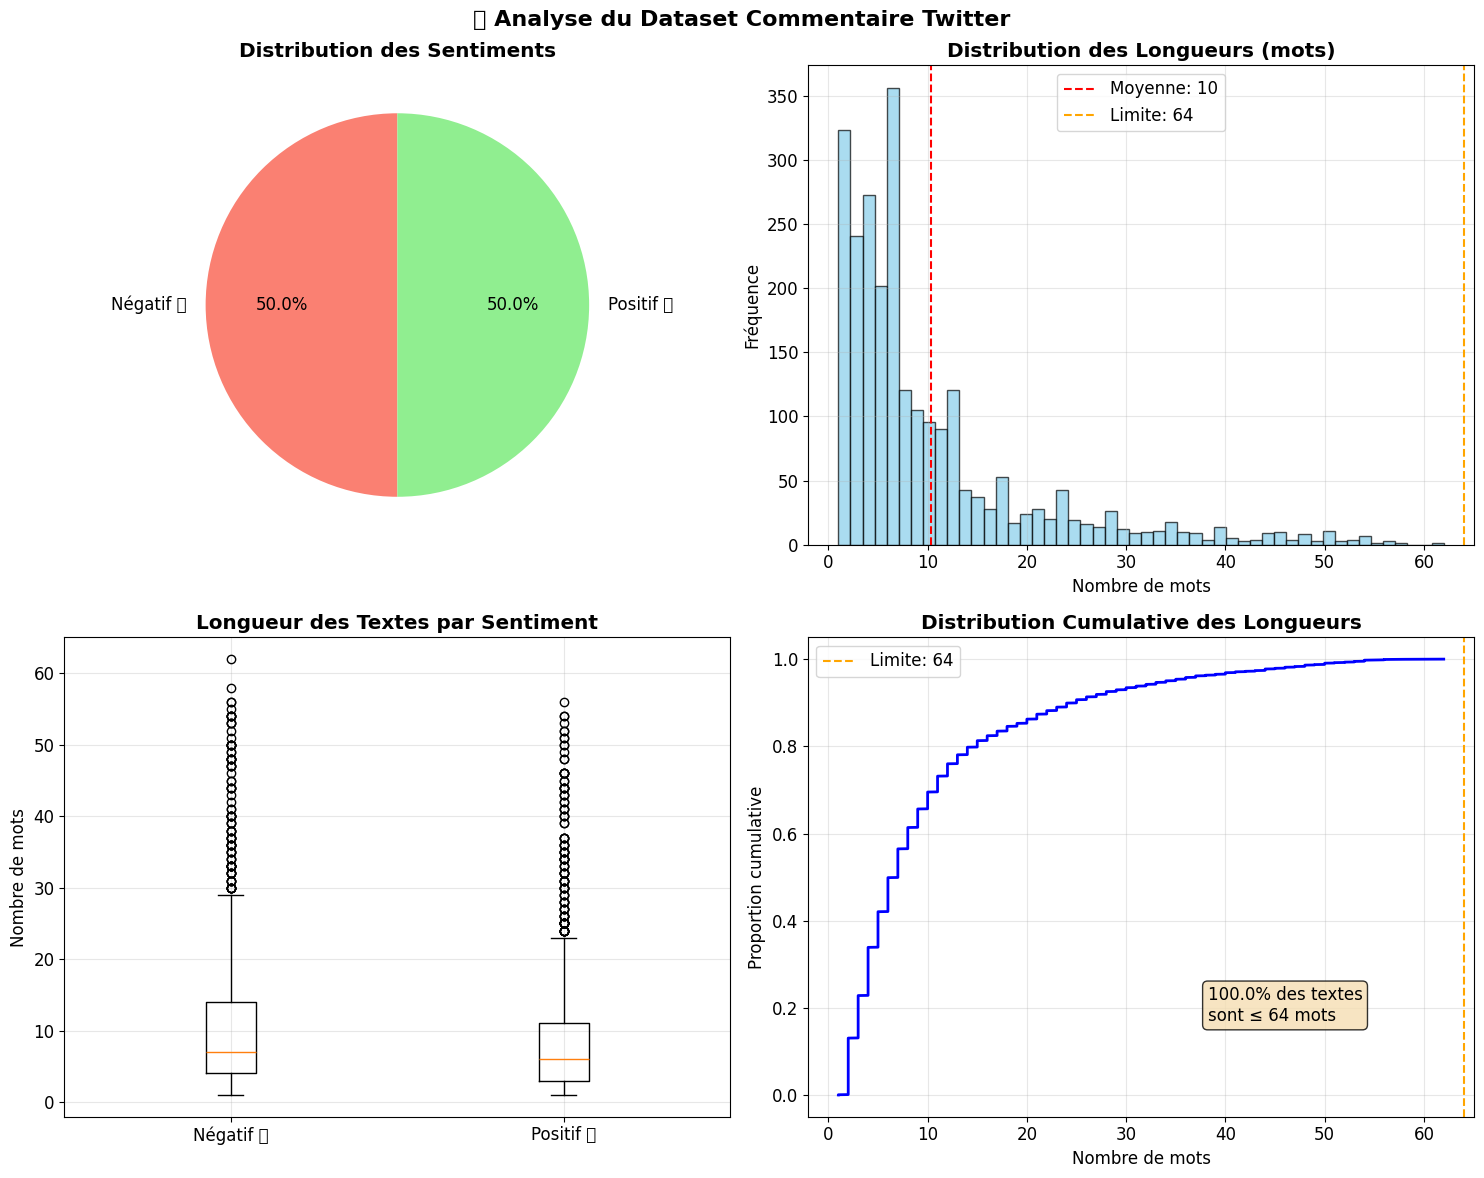


📊 Statistiques importantes:
   📏 100.0% des textes sont ≤ 64 mots
   ✂️ 0.0% seront tronqués lors de la tokenisation
   📈 Longueur moyenne: 10.4 mots
   📊 Écart-type: 10.5 mots


In [8]:
# 📊 Visualisation des statistiques des données
def visualiser_donnees_imdb(texts, labels):
    """
    Crée des visualisations pour comprendre le dataset Sentiment Analysis Twitter Data
    """
    # Calculs préliminaires
    text_lengths = [len(text.split()) for text in texts]
    char_lengths = [len(text) for text in texts]
    
    # Créer la figure avec plusieurs sous-graphiques
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('📊 Analyse du Dataset Commentaire Twitter', fontsize=16, fontweight='bold')
    
    # 1. Distribution des classes
    unique, counts = np.unique(labels, return_counts=True)
    class_names = ['Négatif 👎', 'Positif 👍']
    colors = ['salmon', 'lightgreen']
    
    axes[0,0].pie(counts, labels=class_names, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('Distribution des Sentiments', fontweight='bold')
    
    # 2. Distribution des longueurs (en mots)
    axes[0,1].hist(text_lengths, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
    axes[0,1].axvline(np.mean(text_lengths), color='red', linestyle='--', label=f'Moyenne: {np.mean(text_lengths):.0f}')
    axes[0,1].axvline(MAX_LENGTH, color='orange', linestyle='--', label=f'Limite: {MAX_LENGTH}')
    axes[0,1].set_title('Distribution des Longueurs (mots)', fontweight='bold')
    axes[0,1].set_xlabel('Nombre de mots')
    axes[0,1].set_ylabel('Fréquence')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Box plot par sentiment
    pos_lengths = [text_lengths[i] for i, label in enumerate(labels) if label == 1]
    neg_lengths = [text_lengths[i] for i, label in enumerate(labels) if label == 0]
    
    axes[1,0].boxplot([neg_lengths, pos_lengths], labels=['Négatif 👎', 'Positif 👍'])
    axes[1,0].set_title('Longueur des Textes par Sentiment', fontweight='bold')
    axes[1,0].set_ylabel('Nombre de mots')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Distribution cumulative
    sorted_lengths = np.sort(text_lengths)
    y = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
    axes[1,1].plot(sorted_lengths, y, 'b-', linewidth=2)
    axes[1,1].axvline(MAX_LENGTH, color='orange', linestyle='--', label=f'Limite: {MAX_LENGTH}')
    axes[1,1].set_title('Distribution Cumulative des Longueurs', fontweight='bold')
    axes[1,1].set_xlabel('Nombre de mots')
    axes[1,1].set_ylabel('Proportion cumulative')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].legend()
    
    # Pourcentage de textes sous la limite
    under_limit = sum(1 for length in text_lengths if length <= MAX_LENGTH) / len(text_lengths) * 100
    axes[1,1].text(0.6, 0.2, f'{under_limit:.1f}% des textes\nsont ≤ {MAX_LENGTH} mots', 
                  transform=axes[1,1].transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques importantes
    print(f"\n📊 Statistiques importantes:")
    print(f"   📏 {under_limit:.1f}% des textes sont ≤ {MAX_LENGTH} mots")
    print(f"   ✂️ {100-under_limit:.1f}% seront tronqués lors de la tokenisation")
    print(f"   📈 Longueur moyenne: {np.mean(text_lengths):.1f} mots")
    print(f"   📊 Écart-type: {np.std(text_lengths):.1f} mots")

# Créer les visualisations
print("📊 Création des visualisations du dataset Bitcoin Sentiment Analysis Twitter Data:")
visualiser_donnees_imdb(train_texts, train_labels)

## 🧠 Construction du Modèle avec BERTweet

In [9]:
# 🧠 Chargement du modèle BERTweet pré-entraîné
print("🧠 Chargement de BERTweet pré-entraîné...")
print("(Cela peut prendre quelques minutes la première fois)\n")

# Chargement depuis Hugging Face
bertweet_model = TFAutoModel.from_pretrained(
    MODEL_NAME,
    return_dict=True,           # Retour sous forme de dictionnaire au lieu de tuple
)

print("✅ BERTweet chargé avec succès !")
print(f"📊 Nombre de paramètres: {bertweet_model.num_parameters():,}")
print(f"🔤 Vocabulaire: {tokenizer.vocab_size:,} tokens")

bertweet_model.summary()

🧠 Chargement de BERTweet pré-entraîné...
(Cela peut prendre quelques minutes la première fois)



TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further trai

✅ BERTweet chargé avec succès !
📊 Nombre de paramètres: 134,899,968
🔤 Vocabulaire: 64,000 tokens
Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  134899968 
 r)                                                              
                                                                 
Total params: 134899968 (514.60 MB)
Trainable params: 134899968 (514.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# bertweet_model
# └── roberta (couche 0) 
#     ├── embeddings
#     ├── encoder
#     │   ├── layer_0
#     │   ├── layer_1
#     │   ├── ...
#     │   └── layer_11
#     └── pooler
    
def degeler_couches_bertweet(model, seuil=8):
    """Dégeler correctement les couches d'un modèle BERTweet avec détail des paramètres"""
    
    print(f"🔓 Dégel des couches au-dessus de {seuil}...")
    
    # Accéder à la couche RoBERTa
    if hasattr(model, 'roberta'):
        roberta_layer = model.roberta
    else:
        roberta_layer = model.layers[0]
    
    # Geler d'abord tout le modèle
    roberta_layer.trainable = False
    
    # Compteurs pour le résumé
    total_degele = 0
    total_gele = 0
    params_degeles = 0
    params_geles = 0
    
    # Dégeler les couches spécifiques de l'encoder
    if hasattr(roberta_layer, 'encoder'):
        encoder = roberta_layer.encoder
        
        for i, layer in enumerate(encoder.layer):
            # Compter les paramètres de cette couche
            layer_params = sum([tf.size(w).numpy() for w in layer.weights])
            
            if i > seuil:
                layer.trainable = True
                print(f"   ✅ Couche {i} dégelée ({layer_params:,} paramètres)")
                total_degele += 1
                params_degeles += layer_params
            else:
                layer.trainable = False
                print(f"   ❄️ Couche {i} gelée ({layer_params:,} paramètres)")
                total_gele += 1
                params_geles += layer_params
        
        # Geler le pooler car non utilisé
        if hasattr(roberta_layer, 'pooler') and roberta_layer.pooler is not None:
            pooler_params = sum([tf.size(w).numpy() for w in roberta_layer.pooler.weights])
            roberta_layer.pooler.trainable = True
            if roberta_layer.pooler.trainable:
                print(f"   ✅ Pooler dégelé ({pooler_params:,} paramètres)")
                params_degeles += pooler_params
            else:
                print(f"   ❄️ Pooler gelé ({pooler_params:,} paramètres)")
                params_geles += pooler_params
        
        # Geler les embeddings
        if hasattr(roberta_layer, 'embeddings'):
            emb_params = sum([tf.size(w).numpy() for w in roberta_layer.embeddings.weights])
            roberta_layer.embeddings.trainable = True
            if roberta_layer.embeddings.trainable:
                print(f"   ✅ Embeddings dégelés ({emb_params:,} paramètres)")
                params_degeles += emb_params
            else:
                print(f"   ❄️ Embeddings gelés ({emb_params:,} paramètres)")
                params_geles += emb_params
    
    # Résumé final
    print(f"\n📊 Résumé du dégel:")
    print(f"   🟢 Couches dégelées: {total_degele} ({params_degeles:,} paramètres)")
    print(f"   🔴 Couches gelées: {total_gele} ({params_geles:,} paramètres)")
    print(f"   📈 Ratio entraînable: {params_degeles/(params_degeles+params_geles)*100:.1f}%")
    
    print("🔓 Dégel terminé !")
    return model
    
# Appliquer le dégel correct
#bertweet_model = degeler_couches_bertweet(bertweet_model, -1)

In [ ]:
# 🏗️ Fonction de création du modèle complet
def create_sentiment_model(bertweet_model):
    """
    Crée un modèle de classification de sentiment basé sur BERTweet
    
    Architecture :
    1. BERTweet pré-entraîné (couche de base)
    2. Extraction du token [CLS] (représentation globale)
    3. Dropout pour régularisation
    4. Dense layer pour classification binaire
    
    Args:
        bertweet_model: Modèle BERTweet pré-entraîné
    
    Returns:
        model: Modèle Keras complet
    """
    print("🏗️ Construction de l'architecture complète...")
    
    # Couches d'entrée
    input_ids = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), 
        dtype=tf.int32, 
        name='input_ids'
    )
    attention_mask = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), 
        dtype=tf.int32, 
        name='attention_mask'
    )
    
    print("   ✅ Couches d'entrée créées")
    
    # BERTweet pré-entraîné
    bertweet_output = bertweet_model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    
    # Extraction des embeddings de séquence
    sequence_output = bertweet_output.last_hidden_state  # Shape: (batch_size, seq_len, 768)
    print("   ✅ BERTweet intégré")
    
    # Pooling : extraction du token [CLS] (première position)
    cls_token = sequence_output[:, 0, :]  # Shape: (batch_size, 768)
    print("   ✅ Token [CLS] extrait")

    # Classification head
    x = tf.keras.layers.Dense(128, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(cls_token)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(32, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    # Couche de classification finale
    predictions = tf.keras.layers.Dense(
        NUM_CLASSES, 
        activation='sigmoid',  # Sigmoid pour classification binaire
        name='sentiment_classifier'
    )(x)
    print("   ✅ Couche de classification ajoutée")
    
    # Création du modèle final
    model = tf.keras.Model(
        inputs=[input_ids, attention_mask],
        outputs=predictions,
        name='BERTweet_Sentiment_avec_GeLU'
    )
    
    print("\n✅ Modèle construit avec succès !")
    
    return model

# Création du modèle
model = create_sentiment_model(bertweet_model)

# Informations sur le modèle
total_params = sum(tf.size(var).numpy() for var in model.trainable_variables)
print(f"\n📊 Statistiques du modèle:")
print(f"   🔢 Paramètres totaux: {total_params:,}")
print(f"   🎯 Type de classification: Binaire (sentiment)")
print(f"   📏 Longueur d'entrée: {MAX_LENGTH} tokens")

🏗️ Construction de l'architecture complète...
   ✅ Couches d'entrée créées
   ✅ BERTweet intégré
   ✅ Token [CLS] extrait
   ✅ Couche de classification ajoutée

✅ Modèle construit avec succès !

📊 Statistiques du modèle:
   🔢 Paramètres totaux: 135,002,817
   🎯 Type de classification: Binaire (sentiment)
   📏 Longueur d'entrée: 64 tokens


### 🔧 Test du Modèle

In [12]:
# 🔧 Test du modèle avant entraînement
def tester_modele_avant_entrainement(model, test_dataset):
    """
    Teste que le modèle fonctionne correctement avant l'entraînement
    """
    print("🔧 Test du modèle avant entraînement...\n")
    
    # Prendre un petit batch pour le test
    for batch_features, batch_labels in test_dataset.take(1):
        print(f"📦 Batch de test:")
        print(f"   📏 Taille: {len(batch_labels)} exemples")
        print(f"   📊 Input IDs shape: {batch_features['input_ids'].shape}")
        print(f"   👁️ Attention mask shape: {batch_features['attention_mask'].shape}")
        print(f"   🏷️ Labels shape: {batch_labels.shape}")
        
        # Forward pass (prédiction)
        print(f"\n🔮 Test de prédiction...")
        predictions = model([
            batch_features['input_ids'],
            batch_features['attention_mask']
        ], training=False)
        
        print(f"✅ Prédictions générées !")
        print(f"   📊 Shape des prédictions: {predictions.shape}")
        print(f"   📈 Valeurs min/max: {tf.reduce_min(predictions):.4f} / {tf.reduce_max(predictions):.4f}")
        print(f"   🎯 Moyenne: {tf.reduce_mean(predictions):.4f}")
        
        # Analyse des premières prédictions
        print(f"\n📝 Premières prédictions (avant entraînement):")
        for i in range(min(5, len(predictions))):
            pred_prob = predictions[i].numpy()[0]
            true_label = batch_labels[i].numpy()
            pred_sentiment = "Positif" if pred_prob > 0.5 else "Négatif"
            true_sentiment = "Positif" if true_label == 1 else "Négatif"
            
            print(f"   Exemple {i+1}: Prédit={pred_sentiment} ({pred_prob:.3f}), Vrai={true_sentiment}")
        
        break
    
    print(f"\n💡 Observations:")
    print(f"   🎲 Prédictions aléatoires (modèle non entraîné)")
    print(f"   📊 Valeurs entre 0 et 1 (sigmoid fonctionne)")
    print(f"   ✅ Architecture compatible avec nos données")
    print(f"   🚀 Prêt pour l'entraînement !")

# Tester le modèle
tester_modele_avant_entrainement(model, test_dataset)

🔧 Test du modèle avant entraînement...

📦 Batch de test:
   📏 Taille: 32 exemples
   📊 Input IDs shape: (32, 64)
   👁️ Attention mask shape: (32, 64)
   🏷️ Labels shape: (32,)

🔮 Test de prédiction...
✅ Prédictions générées !
   📊 Shape des prédictions: (32, 1)
   📈 Valeurs min/max: 0.4369 / 0.4940
   🎯 Moyenne: 0.4645

📝 Premières prédictions (avant entraînement):
   Exemple 1: Prédit=Négatif (0.484), Vrai=Négatif
   Exemple 2: Prédit=Négatif (0.469), Vrai=Positif
   Exemple 3: Prédit=Négatif (0.451), Vrai=Négatif
   Exemple 4: Prédit=Négatif (0.459), Vrai=Négatif
   Exemple 5: Prédit=Négatif (0.449), Vrai=Positif

💡 Observations:
   🎲 Prédictions aléatoires (modèle non entraîné)
   📊 Valeurs entre 0 et 1 (sigmoid fonctionne)
   ✅ Architecture compatible avec nos données
   🚀 Prêt pour l'entraînement !


## ⚙️ Compilation du Modèle

Maintenant que notre architecture est construite, configurons l'entraînement :

### 🎯 Configuration des Hyperparamètres

Pour le fine-tuning de BERTweet, nous utiliserons :

- **Loss Function** : `BinaryCrossentropy` (classification binaire)
- **Optimiseur** : `Adam` avec learning rate adaptatif
- **Métriques** : `Accuracy` et `Precision/Recall`
- **Learning Rate** : Plus faible pour préserver les poids pré-entraînés

In [ ]:
# ⚙️ Configuration de l'optimiseur et des métriques
print("⚙️ Configuration de l'entraînement...\n")

# Optimiseur Adam avec learning rate adapté au fine-tuning
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=config['learning_rate'],
    weight_decay=0.01,  # facultatif mais conseillé pour Transformer
    #epsilon=1e-08,
    #clipnorm=1.0
)

print(f"🎯 Optimiseur configuré:")
print(f"   📊 Type: Adam")
print(f"   📈 Learning rate: {config['learning_rate']}")
print(f"   ✂️ Gradient clipping: 1.0")
print(f"   🎯 Epsilon: 1e-08")

# Loss function pour classification binaire
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

print(f"\n📉 Loss function:")
print(f"   🎯 Type: Binary Crossentropy")
print(f"   📊 From logits: False (on utilise sigmoid)")

# Métriques de suivi
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

print(f"\n📊 Métriques de suivi:")
for metric in metrics:
    print(f"   • {metric.name}")

print(f"\n💡 Pourquoi ces choix ?")
print(f"   📈 Learning rate faible: Préserver les connaissances pré-entraînées")
print(f"   ✂️ Gradient clipping: Éviter l'explosion des gradients")
print(f"   📊 Multiple métriques: Vue complète des performances")

2025-07-21 10:06:41,640 - absl - WARNING - At this time, the v2.11+ optimizer `tf.keras.optimizers.AdamW` runs slowly on M1/M2 Macs, please use the legacy TF-Keras optimizer instead, located at `tf.keras.optimizers.legacy.AdamW`.


⚙️ Configuration de l'entraînement...

🎯 Optimiseur configuré:
   📊 Type: Adam
   📈 Learning rate: 2e-05
   ✂️ Gradient clipping: 1.0
   🎯 Epsilon: 1e-08

📉 Loss function:
   🎯 Type: Binary Crossentropy
   📊 From logits: False (on utilise sigmoid)

📊 Métriques de suivi:
   • accuracy
   • precision
   • recall

💡 Pourquoi ces choix ?
   📈 Learning rate faible: Préserver les connaissances pré-entraînées
   ✂️ Gradient clipping: Éviter l'explosion des gradients
   📊 Multiple métriques: Vue complète des performances


### 🔧 Compilation du Modèle

Compilons maintenant notre modèle avec ces paramètres :

In [14]:
# 🔧 Compilation du modèle
print("🔧 Compilation du modèle...\n")

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=metrics
)

print("✅ Modèle compilé avec succès !")

# Vérification de la configuration
print(f"\n📋 Configuration finale:")
print(f"   🎯 Tâche: Classification binaire de sentiment")
print(f"   🧠 Architecture: BERTweet + Classification head")
print(f"   📊 Paramètres: {sum(tf.size(var).numpy() for var in model.trainable_variables):,}")
print(f"   ⚡ Optimiseur: {optimizer.__class__.__name__}")
print(f"   📉 Loss: {loss_fn.__class__.__name__}")
print(f"   📈 Métriques: {[m.name for m in metrics]}")

print(f"\n🚀 Modèle prêt pour l'entraînement !")

🔧 Compilation du modèle...

✅ Modèle compilé avec succès !

📋 Configuration finale:
   🎯 Tâche: Classification binaire de sentiment
   🧠 Architecture: BERTweet + Classification head
   📊 Paramètres: 135,002,817
   ⚡ Optimiseur: AdamW
   📉 Loss: BinaryCrossentropy
   📈 Métriques: ['accuracy', 'precision', 'recall']

🚀 Modèle prêt pour l'entraînement !


## 📞 Configuration des Callbacks

Les callbacks nous permettent de surveiller et contrôler l'entraînement :

### 🎯 Callbacks Utiles pour le Fine-tuning

- **EarlyStopping** : Arrêt automatique si pas d'amélioration
- **ReduceLROnPlateau** : Réduction du learning rate si stagnation
- **ModelCheckpoint** : Sauvegarde du meilleur modèle
- **CSVLogger** : Enregistrement des métriques

In [ ]:
# 📞 Configuration des callbacks pour l'entraînement
print("📞 Configuration des callbacks...\n")

TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

# Early Stopping - arrêt si pas d'amélioration

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Métrique à surveiller
    patience=1,                 # Nombre d'epochs sans amélioration
    min_delta=1e-3,
    restore_best_weights=True,  # Restaurer les meilleurs poids
    verbose=1
)

# Reduce Learning Rate - diminution si stagnation
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',         # Métrique à surveiller
    factor=0.5,                 # Facteur de réduction (LR = LR * 0.5)
    patience=1,                 # Patience avant réduction
    min_lr=1e-7,                # Learning rate minimum
    cooldown=1,
    verbose=1
)

# Model Checkpoint - sauvegarde du meilleur modèle
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'models/best_model_bertweet_{TIMESTAMP}.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# CSV Logger - enregistrement des métriques
csv_logger = tf.keras.callbacks.CSVLogger(
    f'models/training_log_bertweet_{TIMESTAMP}.csv',
    append=True
)

lr_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch}: lr = {logs.get('lr', 'N/A')}")
)

# Liste complète des callbacks
callbacks = [
    early_stopping,
    reduce_lr,
    checkpoint,
    csv_logger,
    lr_callback
]

print(f"\n✅ {len(callbacks)} callbacks configurés:")
for i, cb in enumerate(callbacks, 1):
    print(f"   {i}. {cb.__class__.__name__}")

print(f"\n💡 Avantages des callbacks:")
print(f"   🛑 Évite le surapprentissage (Early Stopping)")
print(f"   📈 Optimise l'apprentissage (ReduceLR)")
print(f"   💾 Sauvegarde automatique (Checkpoint)")
print(f"   📊 Traçabilité complète (CSV Logger)")

📞 Configuration des callbacks...


✅ 5 callbacks configurés:
   1. EarlyStopping
   2. ReduceLROnPlateau
   3. ModelCheckpoint
   4. CSVLogger
   5. LambdaCallback

💡 Avantages des callbacks:
   🛑 Évite le surapprentissage (Early Stopping)
   📈 Optimise l'apprentissage (ReduceLR)
   💾 Sauvegarde automatique (Checkpoint)
   📊 Traçabilité complète (CSV Logger)


## 🚀 Lancement de l'Entraînement (Fine-tuning)

C'est le moment de démarrer le fine-tuning de BERTweet !

### 🎯 Stratégie de Fine-tuning

Nous utilisons une approche **End-to-End** :
- Toutes les couches sont entraînables dès le début
- Learning rate faible pour préserver les connaissances
- Régularisation avec dropout
- Surveillance avec callbacks

In [16]:
# 🚀 Préparation au lancement de l'entraînement
print("🚀 Préparation de l'entraînement...\n")

# Vérification des paramètres d'entraînement
print("📊 Paramètres d'entraînement:")
print(f"   📈 Epochs: {EPOCHS}")
print(f"   📦 Batch size: {BATCH_SIZE}")
print(f"   📏 Sequence length: {MAX_LENGTH}")
print(f"   🎯 Learning rate: {LEARNING_RATE}")

# Calcul du nombre de steps par epoch
steps_per_epoch = len(list(train_dataset.as_numpy_iterator()))
validation_steps = len(list(test_dataset.as_numpy_iterator()))


print(f"\n📊 Configuration des données:")
print(f"   🏋️ Steps par epoch: {steps_per_epoch}")
print(f"   ✅ Steps de validation: {validation_steps}")
print(f"   ⏱️ Temps estimé: ~{EPOCHS * 3}-{EPOCHS * 5} minutes")

# Estimation mémoire GPU
print(f"\n💾 Utilisation mémoire estimée:")
print(f"   🖥️ GPU: ~2-4 GB")
print(f"   🧠 Paramètres: {sum(tf.size(var).numpy() for var in model.trainable_variables):,}")

print(f"\n🎯 Objectif: Classifier le sentiment (Positif/Négatif)")
print(f"📊 Métrique principale: Validation Accuracy")
print(f"\n🚀 Lancement de l'entraînement !")
print("=" * 60)

🚀 Préparation de l'entraînement...

📊 Paramètres d'entraînement:
   📈 Epochs: 6
   📦 Batch size: 32
   📏 Sequence length: 64
   🎯 Learning rate: 2e-05

📊 Configuration des données:
   🏋️ Steps par epoch: 78
   ✅ Steps de validation: 20
   ⏱️ Temps estimé: ~18-30 minutes

💾 Utilisation mémoire estimée:
   🖥️ GPU: ~2-4 GB
   🧠 Paramètres: 135,002,817

🎯 Objectif: Classifier le sentiment (Positif/Négatif)
📊 Métrique principale: Validation Accuracy

🚀 Lancement de l'entraînement !


2025-07-21 10:06:41.735989: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-21 10:06:41.758350: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# 🚀 Entraînement du modèle
print("🔥 DÉBUT DE L'ENTRAÎNEMENT\n")

# Enregistrer l'heure de début
import time
start_time = time.time()

# Entraînement avec fit()
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=1
)

# Calcul du temps d'entraînement
end_time = time.time()
training_time = end_time - start_time

print(f"\n🎉 ENTRAÎNEMENT TERMINÉ !")
print(f"⏱️ Temps total: {training_time/60:.1f} minutes")
print(f"⚡ Temps par epoch: {training_time/EPOCHS:.1f} secondes")

# Sauvegarde de l'historique
import pickle
with open('training_history_bertweet.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print(f"\n💾 Historique sauvegardé dans 'training_history_bertweet.pkl'")
print(f"📊 Modèle sauvegardé automatiquement par ModelCheckpoint")

🔥 DÉBUT DE L'ENTRAÎNEMENT

Epoch 1/6
78/78 [==============================] - ETA: 0s - loss: 6.2111 - accuracy: 0.5668 - precision: 0.5615 - recall: 0.6097
Epoch 1: val_accuracy improved from -inf to 0.73948, saving model to models/best_model_bertweet_20250721_100641.h5
Epoch 0: lr = 1.9999999494757503e-05
78/78 [==============================] - 302s 4s/step - loss: 6.2111 - accuracy: 0.5668 - precision: 0.5615 - recall: 0.6097 - val_loss: 5.8849 - val_accuracy: 0.7395 - val_precision: 0.8364 - val_recall: 0.5955 - lr: 2.0000e-05
Epoch 2/6
78/78 [==============================] - ETA: 0s - loss: 5.8408 - accuracy: 0.7611 - precision: 0.7449 - recall: 0.7943
Epoch 2: val_accuracy improved from 0.73948 to 0.81715, saving model to models/best_model_bertweet_20250721_100641.h5
Epoch 1: lr = 1.9999999494757503e-05
78/78 [==============================] - 385s 5s/step - loss: 5.8408 - accuracy: 0.7611 - precision: 0.7449 - recall: 0.7943 - val_loss: 5.6317 - val_accuracy: 0.8172 - val_prec

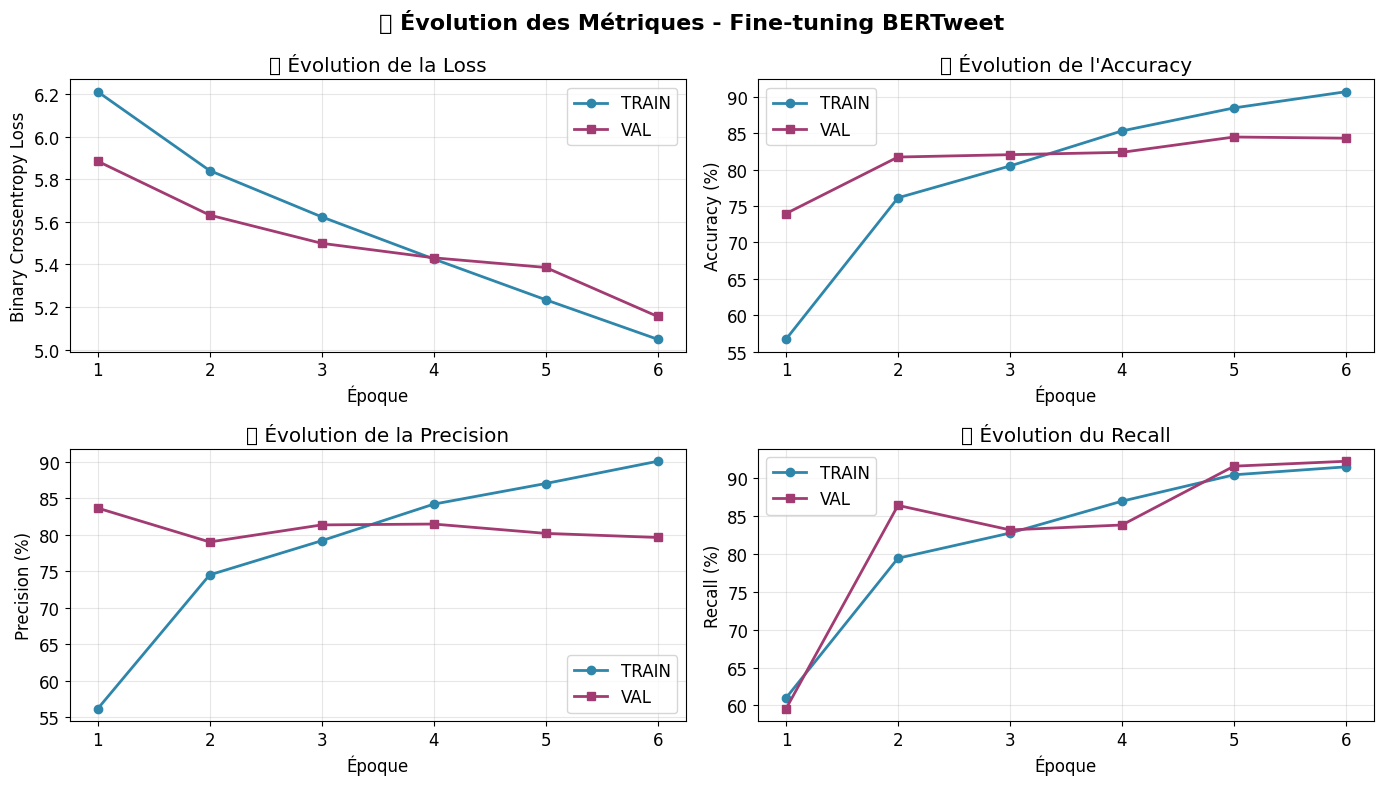

In [18]:
def plot_training_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']

    # Couleurs pour les graphiques
    colors = {'train': '#2E86AB', 'val': '#A23B72'}
    
    epochs_range = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(14, 8))
    plt.suptitle('📊 Évolution des Métriques - Fine-tuning BERTweet', fontsize=16, fontweight='bold')

    plot_labels = [
        ('loss', '📉 Évolution de la Loss', 'Époque', 'Binary Crossentropy Loss'),
        ('accuracy', '📊 Évolution de l\'Accuracy', 'Époque', 'Accuracy (%)'),
        ('precision', '🎯 Évolution de la Precision', 'Époque', 'Precision (%)'),
        ('recall', '📊 Évolution du Recall', 'Époque', 'Recall (%)')
    ]

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)

        if i == 0:
            plt.plot(epochs_range, history.history[metric], color=colors['train'], marker='o', linewidth=2, label=f'TRAIN')
            plt.plot(epochs_range,history.history[f'val_{metric}'], color=colors['val'], marker='s', linewidth=2, label=f'VAL')
        else:
            plt.plot(epochs_range, [acc*100 for acc in history.history[metric]], color=colors['train'], marker='o', linewidth=2, label=f'TRAIN')
            plt.plot(epochs_range, [acc*100 for acc in history.history[f'val_{metric}']], color=colors['val'], marker='s', linewidth=2, label=f'VAL')
        plt.title(f'{plot_labels[i][1]}')
        plt.xlabel(plot_labels[i][2])
        plt.ylabel(plot_labels[i][3])
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_metrics(history)

### 📊 Analyse Détaillée des Résultats

Créons un tableau récapitulatif des performances :

In [19]:
# 📊 Analyse statistique détaillée
def analyser_performances_entrainement(history):
    """
    Analyse complète des performances d'entraînement
    """
    print("📊 ANALYSE DÉTAILLÉE DES PERFORMANCES\n")
    
    # Extraction des métriques
    metrics = {
        'Loss': {
            'train': history.history['loss'],
            'val': history.history['val_loss']
        },
        'Accuracy': {
            'train': history.history['accuracy'],
            'val': history.history['val_accuracy']
        },
        'Precision': {
            'train': history.history['precision'],
            'val': history.history['val_precision']
        },
        'Recall': {
            'train': history.history['recall'],
            'val': history.history['val_recall']
        }
    }
    
    # Création du tableau récapitulatif
    import pandas as pd
    
    results = []
    for metric_name, values in metrics.items():
        train_final = values['train'][-1]
        val_final = values['val'][-1]
        
        if metric_name == 'Loss':
            train_best = min(values['train'])
            val_best = min(values['val'])
            best_epoch = values['val'].index(val_best) + 1
        else:
            train_best = max(values['train'])
            val_best = max(values['val'])
            best_epoch = values['val'].index(val_best) + 1
        
        results.append({
            'Métrique': metric_name,
            'Train Final': f"{train_final:.4f}",
            'Val Final': f"{val_final:.4f}",
            'Meilleur Val': f"{val_best:.4f}",
            'Époque Opt.': best_epoch,
            'Gap Train-Val': f"{abs(train_final - val_final):.4f}"
        })
    
    df = pd.DataFrame(results)
    print("📋 Tableau récapitulatif:")
    print(df.to_string(index=False))
    
    # Analyse de convergence
    print(f"\n🔍 Analyse de convergence:")
    
    val_acc = metrics['Accuracy']['val']
    if len(val_acc) >= 3:
        last_3_epochs = val_acc[-3:]
        is_stable = max(last_3_epochs) - min(last_3_epochs) < 0.01
        
        if is_stable:
            print(f"   ✅ Convergence stable (variation < 1%)")
        else:
            print(f"   📈 Modèle encore en apprentissage")
    
    # Détection d'overfitting
    train_acc_final = metrics['Accuracy']['train'][-1]
    val_acc_final = metrics['Accuracy']['val'][-1]
    overfitting_gap = train_acc_final - val_acc_final
    
    print(f"\n🎯 Analyse de l'overfitting:")
    if overfitting_gap < 0.02:
        print(f"   ✅ Pas d'overfitting (gap: {overfitting_gap:.4f})")
    elif overfitting_gap < 0.05:
        print(f"   ⚠️ Overfitting léger (gap: {overfitting_gap:.4f})")
    else:
        print(f"   🚨 Overfitting significatif (gap: {overfitting_gap:.4f})")
    
    # F1-Score approximatif
    precision_final = metrics['Precision']['val'][-1]
    recall_final = metrics['Recall']['val'][-1]
    f1_score = 2 * (precision_final * recall_final) / (precision_final + recall_final)
    
    print(f"\n🏆 Score F1 estimé: {f1_score:.4f} ({f1_score*100:.2f}%)")
    
    # Recommandations
    print(f"\n💡 Recommandations:")
    if val_acc_final > 0.90:
        print(f"   🌟 Excellente performance ! Modèle prêt pour la production")
    elif val_acc_final > 0.85:
        print(f"   👍 Très bonne performance, peut être déployé")
    elif val_acc_final > 0.80:
        print(f"   ✅ Performance satisfaisante")
        if overfitting_gap > 0.05:
            print(f"   📝 Conseil: Augmenter la régularisation (dropout)")
    else:
        print(f"   ⚠️ Performance à améliorer")
        print(f"   📝 Conseils: Plus d'epochs, ajuster learning rate, ou plus de données")

# Lancer l'analyse
analyser_performances_entrainement(history)

📊 ANALYSE DÉTAILLÉE DES PERFORMANCES

📋 Tableau récapitulatif:
 Métrique Train Final Val Final Meilleur Val  Époque Opt. Gap Train-Val
     Loss      5.0485    5.1556       5.1556            6        0.1072
 Accuracy      0.9069    0.8430       0.8447            5        0.0638
Precision      0.9004    0.7961       0.8364            1        0.1043
   Recall      0.9150    0.9223       0.9223            6        0.0074

🔍 Analyse de convergence:
   📈 Modèle encore en apprentissage

🎯 Analyse de l'overfitting:
   🚨 Overfitting significatif (gap: 0.0638)

🏆 Score F1 estimé: 0.8546 (85.46%)

💡 Recommandations:
   ✅ Performance satisfaisante
   📝 Conseil: Augmenter la régularisation (dropout)


## 🎯 Évaluation des Performances

Maintenant que notre modèle est entraîné, évaluons ses performances sur l'ensemble de test.

### 📊 Métriques d'Évaluation

Pour une classification binaire de sentiment, nous analyserons :

- **Accuracy** : Pourcentage de prédictions correctes
- **Precision** : Qualité des prédictions positives
- **Recall** : Capacité à détecter les vrais positifs
- **F1-Score** : Moyenne harmonique de precision et recall
- **Matrice de confusion** : Répartition détaillée des erreurs

In [20]:
# 🎯 Évaluation sur l'ensemble de test
print("🎯 ÉVALUATION SUR L'ENSEMBLE DE TEST\n")

# Chargement du meilleur modèle (sauvegardé par ModelCheckpoint)
print("📂 Chargement du meilleur modèle...")
try:
    custom_objects = {'TFRobertaModel': TFRobertaModel}
    best_model = tf.keras.models.load_model(f'models/best_model_bertweet_{TIMESTAMP}.h5', custom_objects=custom_objects)
    print("✅ Meilleur modèle chargé depuis ModelCheckpoint")
except:
    best_model = model  # Utiliser le modèle actuel si pas de sauvegarde
    print("⚠️ Utilisation du modèle actuel (pas de checkpoint trouvé)")

# Évaluation complète
print(f"\n🔬 Évaluation en cours...")
test_results = best_model.evaluate(test_dataset, verbose=1)

# Récupération des métriques
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

# Calcul du F1-Score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"\n📊 RÉSULTATS SUR L'ENSEMBLE DE TEST:")
print(f"═" * 50)
print(f"🎯 Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"🎯 Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"🎯 Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"🏆 F1-Score:  {f1_score:.4f} ({f1_score*100:.2f}%)")
print(f"📉 Loss:      {test_loss:.4f}")
print(f"═" * 50)

# Interprétation des résultats
print(f"\n💭 Interprétation:")
if test_accuracy > 0.90:
    print(f"   🌟 Excellente performance ! Modèle prêt pour la production")
elif test_accuracy > 0.85:
    print(f"   🎉 Très bonne performance ! Modèle fiable")
elif test_accuracy > 0.80:
    print(f"   ✅ Bonne performance, utilisable en pratique")
elif test_accuracy > 0.75:
    print(f"   👍 Performance correcte, peut être améliorée")
else:
    print(f"   ⚠️ Performance insuffisante, nécessite optimisation")

# Analyse équilibre Precision/Recall
balance = abs(test_precision - test_recall)
if balance < 0.05:
    print(f"   ⚖️ Bon équilibre Precision/Recall (diff: {balance:.3f})")
else:
    print(f"   ⚖️ Déséquilibre Precision/Recall (diff: {balance:.3f})")
    if test_precision > test_recall:
        print(f"      → Modèle conservateur (peu de faux positifs)")
    else:
        print(f"      → Modèle permissif (peu de faux négatifs)")

🎯 ÉVALUATION SUR L'ENSEMBLE DE TEST

📂 Chargement du meilleur modèle...


2025-07-21 10:55:20,373 - absl - WARNING - At this time, the v2.11+ optimizer `tf.keras.optimizers.AdamW` runs slowly on M1/M2 Macs, please use the legacy TF-Keras optimizer instead, located at `tf.keras.optimizers.legacy.AdamW`.


✅ Meilleur modèle chargé depuis ModelCheckpoint

🔬 Évaluation en cours...
20/20 [==============================] - 17s 753ms/step - loss: 5.3858 - accuracy: 0.8447 - precision: 0.8017 - recall: 0.9159

📊 RÉSULTATS SUR L'ENSEMBLE DE TEST:
══════════════════════════════════════════════════
🎯 Accuracy:  0.8447 (84.47%)
🎯 Precision: 0.8017 (80.17%)
🎯 Recall:    0.9159 (91.59%)
🏆 F1-Score:  0.8550 (85.50%)
📉 Loss:      5.3858
══════════════════════════════════════════════════

💭 Interprétation:
   ✅ Bonne performance, utilisable en pratique
   ⚖️ Déséquilibre Precision/Recall (diff: 0.114)
      → Modèle permissif (peu de faux négatifs)


### 🔍 Matrice de Confusion

Analysons en détail les types d'erreurs commises par notre modèle :

In [21]:
# 🔍 Génération des prédictions pour la matrice de confusion
print("🔍 Génération des prédictions pour analyse détaillée...\n")

# Récupération des vraies étiquettes et prédictions
y_true = []
y_pred = []
y_pred_proba = []

print("📊 Collecte des prédictions...")
for batch_features, batch_labels in test_dataset:
    # Prédictions
    predictions = best_model([
        batch_features['input_ids'],
        batch_features['attention_mask']
    ], training=False)
    
    # Conversion en listes
    y_true.extend(batch_labels.numpy())
    y_pred_proba.extend(predictions.numpy().flatten())
    y_pred.extend((predictions.numpy() > 0.5).astype(int).flatten())

print(f"✅ {len(y_true)} prédictions collectées")

# Conversion en arrays numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print(f"📊 Distribution des vraies étiquettes:")
print(f"   Négatives (0): {np.sum(y_true == 0)} ({np.sum(y_true == 0)/len(y_true)*100:.1f}%)")
print(f"   Positives (1): {np.sum(y_true == 1)} ({np.sum(y_true == 1)/len(y_true)*100:.1f}%)")

print(f"\n🎯 Distribution des prédictions:")
print(f"   Négatives (0): {np.sum(y_pred == 0)} ({np.sum(y_pred == 0)/len(y_pred)*100:.1f}%)")
print(f"   Positives (1): {np.sum(y_pred == 1)} ({np.sum(y_pred == 1)/len(y_pred)*100:.1f}%)")

🔍 Génération des prédictions pour analyse détaillée...

📊 Collecte des prédictions...
✅ 618 prédictions collectées
📊 Distribution des vraies étiquettes:
   Négatives (0): 309 (50.0%)
   Positives (1): 309 (50.0%)

🎯 Distribution des prédictions:
   Négatives (0): 265 (42.9%)
   Positives (1): 353 (57.1%)


📈 Création de la matrice de confusion...



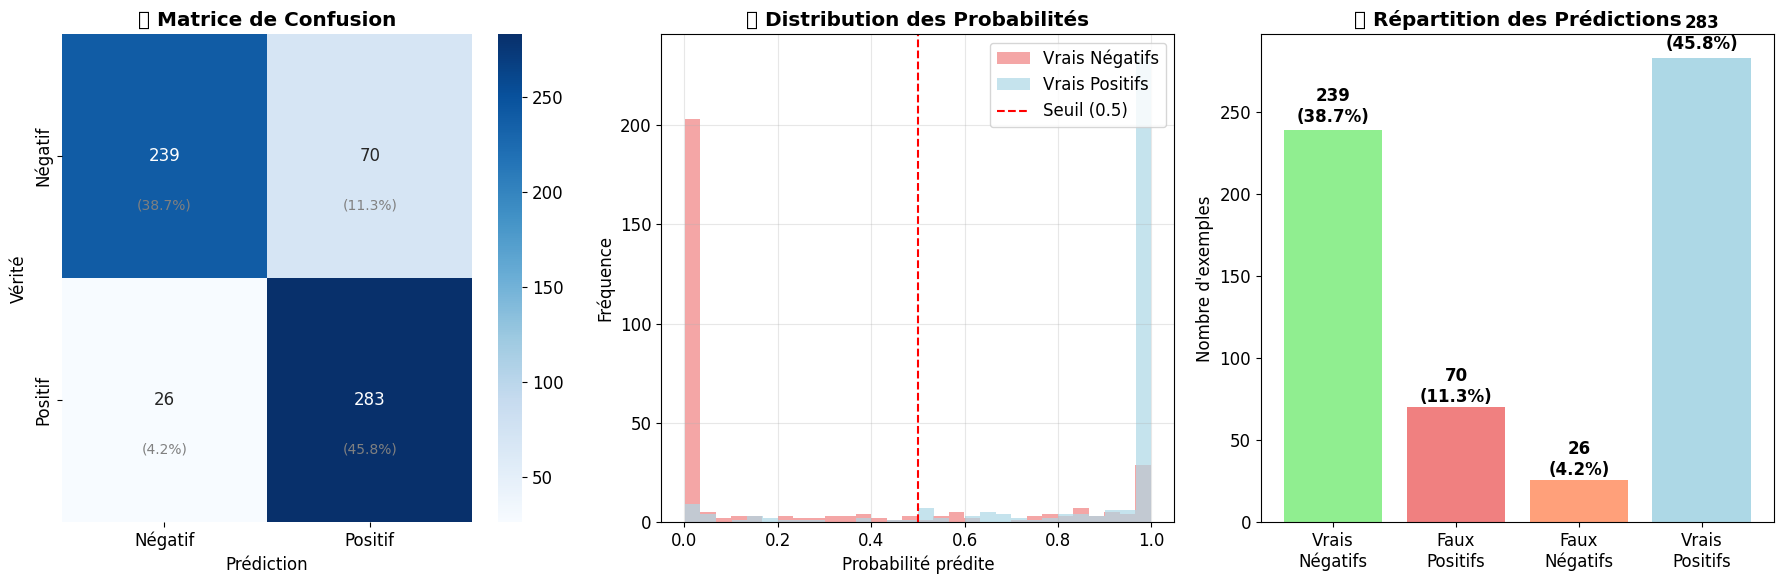

📋 Analyse détaillée de la matrice:
   ✅ Vrais Négatifs (TN):   239 (38.7%)
   ❌ Faux Positifs (FP):     70 (11.3%) - Erreur Type I
   ❌ Faux Négatifs (FN):     26 (4.2%) - Erreur Type II
   ✅ Vrais Positifs (TP):   283 (45.8%)

🎯 Interprétation des erreurs:
   📊 Plus de Faux Positifs: Le modèle tend à sur-classifier comme positif
   💡 Conseil: Augmenter le seuil de décision (> 0.5)


In [22]:
# 📈 Création de la matrice de confusion et visualisations
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def visualiser_matrice_confusion(y_true, y_pred, y_pred_proba):
    """
    Crée une visualisation complète de la matrice de confusion
    """
    print("📈 Création de la matrice de confusion...\n")
    
    # Calcul de la matrice
    cm = confusion_matrix(y_true, y_pred)
    
    # Configuration de la figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Matrice de confusion
    ax1 = axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Négatif', 'Positif'],
                yticklabels=['Négatif', 'Positif'], ax=ax1)
    ax1.set_title('🔍 Matrice de Confusion', fontweight='bold')
    ax1.set_xlabel('Prédiction')
    ax1.set_ylabel('Vérité')
    
    # Ajout des pourcentages
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            percentage = cm[i, j] / total * 100
            ax1.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    # 2. Distribution des probabilités prédites
    ax2 = axes[1]
    
    # Séparer par classe réelle
    neg_probs = y_pred_proba[y_true == 0]
    pos_probs = y_pred_proba[y_true == 1]
    
    ax2.hist(neg_probs, bins=30, alpha=0.7, label='Vrais Négatifs', color='lightcoral')
    ax2.hist(pos_probs, bins=30, alpha=0.7, label='Vrais Positifs', color='lightblue')
    ax2.axvline(x=0.5, color='red', linestyle='--', label='Seuil (0.5)')
    
    ax2.set_title('📊 Distribution des Probabilités', fontweight='bold')
    ax2.set_xlabel('Probabilité prédite')
    ax2.set_ylabel('Fréquence')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Analyse des erreurs
    ax3 = axes[2]
    
    # Types d'erreurs
    tn, fp, fn, tp = cm.ravel()
    
    categories = ['Vrais\nNégatifs', 'Faux\nPositifs', 'Faux\nNégatifs', 'Vrais\nPositifs']
    values = [tn, fp, fn, tp]
    colors = ['lightgreen', 'lightcoral', 'lightsalmon', 'lightblue']
    
    bars = ax3.bar(categories, values, color=colors)
    ax3.set_title('📊 Répartition des Prédictions', fontweight='bold')
    ax3.set_ylabel('Nombre d\'exemples')
    
    # Ajout des valeurs sur les barres
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value}\n({value/total*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Analyse textuelle
    print(f"📋 Analyse détaillée de la matrice:")
    print(f"   ✅ Vrais Négatifs (TN):  {tn:4d} ({tn/total*100:.1f}%)")
    print(f"   ❌ Faux Positifs (FP):   {fp:4d} ({fp/total*100:.1f}%) - Erreur Type I")
    print(f"   ❌ Faux Négatifs (FN):   {fn:4d} ({fn/total*100:.1f}%) - Erreur Type II")
    print(f"   ✅ Vrais Positifs (TP):  {tp:4d} ({tp/total*100:.1f}%)")
    
    print(f"\n🎯 Interprétation des erreurs:")
    if fp > fn:
        print(f"   📊 Plus de Faux Positifs: Le modèle tend à sur-classifier comme positif")
        print(f"   💡 Conseil: Augmenter le seuil de décision (> 0.5)")
    elif fn > fp:
        print(f"   📊 Plus de Faux Négatifs: Le modèle tend à sous-classifier comme positif")
        print(f"   💡 Conseil: Diminuer le seuil de décision (< 0.5)")
    else:
        print(f"   ⚖️ Erreurs équilibrées: Bon seuil de décision")

# Génération des visualisations
visualiser_matrice_confusion(y_true, y_pred, y_pred_proba)

### 📝 Rapport de Classification

Générons un rapport détaillé avec toutes les métriques :

In [23]:
# 📝 Rapport de classification détaillé
print("📝 RAPPORT DE CLASSIFICATION DÉTAILLÉ\n")

# Rapport scikit-learn
class_report = classification_report(y_true, y_pred, 
                                   target_names=['Négatif', 'Positif'],
                                   output_dict=True)

print("📊 Métriques par classe:")
print("═" * 70)
print(f"{'Classe':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("═" * 70)

for class_name in ['Négatif', 'Positif']:
    metrics = class_report[class_name]
    print(f"{class_name:<10} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} "
          f"{metrics['f1-score']:<10.4f} {int(metrics['support']):<10}")

print("═" * 70)
print(f"{'Macro Avg':<10} {class_report['macro avg']['precision']:<10.4f} "
      f"{class_report['macro avg']['recall']:<10.4f} "
      f"{class_report['macro avg']['f1-score']:<10.4f} "
      f"{int(class_report['macro avg']['support']):<10}")
print(f"{'Weighted Avg':<10} {class_report['weighted avg']['precision']:<10.4f} "
      f"{class_report['weighted avg']['recall']:<10.4f} "
      f"{class_report['weighted avg']['f1-score']:<10.4f} "
      f"{int(class_report['weighted avg']['support']):<10}")

# Analyse de la qualité globale
overall_f1 = class_report['weighted avg']['f1-score']
print(f"\n🏆 Score F1 Global: {overall_f1:.4f} ({overall_f1*100:.2f}%)")

print(f"\n💭 Évaluation de la qualité:")
if overall_f1 > 0.90:
    print(f"   🌟 Qualité exceptionnelle - Modèle de production")
elif overall_f1 > 0.85:
    print(f"   🎉 Excellente qualité - Prêt pour déploiement")
elif overall_f1 > 0.80:
    print(f"   ✅ Bonne qualité - Utilisable en pratique")
elif overall_f1 > 0.75:
    print(f"   👍 Qualité correcte - Améliorations possibles")
else:
    print(f"   ⚠️ Qualité insuffisante - Optimisation nécessaire")

# Comparaison avec un baseline
baseline_accuracy = max(np.sum(y_true == 0), np.sum(y_true == 1)) / len(y_true)
improvement = test_accuracy - baseline_accuracy

print(f"\n📊 Comparaison avec baseline:")
print(f"   🎯 Accuracy modèle: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   📊 Baseline (classe majoritaire): {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"   📈 Amélioration: +{improvement:.4f} (+{improvement*100:.2f} points)")

if improvement > 0.20:
    print(f"   🚀 Amélioration exceptionnelle !")
elif improvement > 0.10:
    print(f"   🎉 Excellente amélioration !")
elif improvement > 0.05:
    print(f"   ✅ Bonne amélioration")
else:
    print(f"   ⚠️ Amélioration modeste")

📝 RAPPORT DE CLASSIFICATION DÉTAILLÉ

📊 Métriques par classe:
══════════════════════════════════════════════════════════════════════
Classe     Precision  Recall     F1-Score   Support   
══════════════════════════════════════════════════════════════════════
Négatif    0.9019     0.7735     0.8328     309       
Positif    0.8017     0.9159     0.8550     309       
══════════════════════════════════════════════════════════════════════
Macro Avg  0.8518     0.8447     0.8439     618       
Weighted Avg 0.8518     0.8447     0.8439     618       

🏆 Score F1 Global: 0.8439 (84.39%)

💭 Évaluation de la qualité:
   ✅ Bonne qualité - Utilisable en pratique

📊 Comparaison avec baseline:
   🎯 Accuracy modèle: 0.8447 (84.47%)
   📊 Baseline (classe majoritaire): 0.5000 (50.00%)
   📈 Amélioration: +0.3447 (+34.47 points)
   🚀 Amélioration exceptionnelle !


## 🔮 Fonction de Prédiction Interactive

Créons une fonction pratique pour tester notre modèle sur de nouvelles phrases !

In [24]:
# 🔮 Fonction de prédiction de sentiment
def predire_sentiment(texte, modele=None, tokenizer=tokenizer, max_length=MAX_LENGTH, verbose=True):
    """
    Prédit le sentiment d'un texte donné
    
    Args:
        texte (str): Texte à analyser
        modele: Modèle à utiliser (par défaut le meilleur modèle)
        tokenizer: Tokenizer BERTweet
        max_length (int): Longueur maximale de séquence
        verbose (bool): Affichage détaillé
    
    Returns:
        dict: Résultats de prédiction
    """

    texte = preprocess_crypto_text(texte)
    
    # Utiliser le meilleur modèle par défaut
    if modele is None:
        try:
            modele = tf.keras.models.load_model(f'models/best_model_bertweet_{TIMESTAMP}.h5')
        except:
            #print("❌ Erreur lors du chargement du modèle. Utilisation du modèle actuel.")
            modele = best_model  # Fallback sur le modèle actuel
    
    if verbose:
        print(f"🔮 Analyse du sentiment pour: \"{texte}\"\n")
    
    # Tokenisation du texte
    tokens = tokenizer(
        texte,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    
    if verbose:
        print(f"📝 Tokenisation:")
        decoded_tokens = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
        # Afficher seulement les tokens non-padding
        real_tokens = [tok for tok in decoded_tokens if tok != '[PAD]'][:20]  # Limiter l'affichage
        print(f"   🔤 Tokens: {' '.join(real_tokens)}{'...' if len(real_tokens) == 20 else ''}")
        print(f"   📏 Longueur: {len([tok for tok in decoded_tokens if tok != '[PAD]'])} tokens")
    
    # Prédiction
    prediction = modele([
        tokens['input_ids'],
        tokens['attention_mask']
    ], training=False)
    
    # Extraction des résultats
    probabilite = float(prediction[0][0])
    sentiment = "Positif" if probabilite > 0.5 else "Négatif"
    confiance = max(probabilite, 1 - probabilite)
    
    if verbose:
        print(f"\n🎯 Résultats:")
        print(f"   📊 Sentiment: {sentiment}")
        print(f"   📈 Probabilité: {probabilite:.4f}")
        print(f"   🎯 Confiance: {confiance:.4f} ({confiance*100:.1f}%)")
        
        # Interprétation de la confiance
        if confiance > 0.9:
            print(f"   💪 Très haute confiance - Prédiction très fiable")
        elif confiance > 0.8:
            print(f"   ✅ Haute confiance - Prédiction fiable")
        elif confiance > 0.7:
            print(f"   👍 Confiance modérée - Prédiction raisonnable")
        elif confiance > 0.6:
            print(f"   ⚠️ Faible confiance - Prédiction incertaine")
        else:
            print(f"   🤔 Très faible confiance - Texte ambigu")
    
    return {
        'texte': texte,
        'sentiment': sentiment,
        'probabilite': probabilite,
        'confiance': confiance,
        'tokens': len([tok for tok in tokenizer.convert_ids_to_tokens(tokens['input_ids'][0]) if tok != '[PAD]'])
    }

print("✅ Fonction de prédiction créée !")
print("🎯 Utilisez: predire_sentiment('Votre texte ici')")

✅ Fonction de prédiction créée !
🎯 Utilisez: predire_sentiment('Votre texte ici')


### 🧪 Tests sur des Exemples Variés

Testons notre modèle sur différents types de textes :

In [25]:
# 🧪 Tests sur des exemples variés
exemples_tests = [
    # Exemples clairement positifs
    "Big respect @user 🙌 Crypto’s future looks solid! 🔥 #Web3 #Bullish",
    "$SOL is pumping again! 🔥 Let’s ride it 🌊🚀 #CryptoSeason #SOL",
    "This is why I stay in crypto 💡 Props to @user! #DeFi #CryptoWins 🎉",
    
    # Exemples clairement négatifs
    "Really @user? Another rug? 😡 We need builders, not scams. #CryptoScam 🚨",
    "$XYZ crashing again… 2025 vibes 😓 Where’s the real utility? #CryptoCrash 📉",
    "So much hype, zero delivery. @user promised moon, gave dust 🌪️ #Disappointed",
    
    # Exemples neutres/ambigus
    "Interesting move @user 🤔 Let’s see how it plays out. #CryptoNews",
    "New token drop… $PEPE 2.0 or forgettable? 🤷‍♂️ Good luck @user. #NewToken",
    "$BTC flat — no pump, no dump. Thoughts, @user? 😶",
    
    # Exemples avec sarcasme/ironie
    "Wow, another 'revolutionary' L1 from @user 😅 Just what we needed. #SoInnovative",
    "Congrats @user, coin #4,328 launched today 🥳 Pure genius. #Web3Genius",
    "Another 'can’t miss' gem to lose money on 👏 Thanks @user 😂 #CryptoLife",
]

print("🧪 TESTS SUR EXEMPLES VARIÉS\n")
print("═" * 80)

resultats_tests = []

for i, exemple in enumerate(exemples_tests, 1):
    print(f"\n📝 Test {i}/{len(exemples_tests)}:")
    print("─" * 60)
    
    resultat = predire_sentiment(exemple, verbose=True)
    resultats_tests.append(resultat)
    
    print("─" * 60)

print(f"\n✅ Tests terminés sur {len(exemples_tests)} exemples !")

🧪 TESTS SUR EXEMPLES VARIÉS

════════════════════════════════════════════════════════════════════════════════

📝 Test 1/12:
────────────────────────────────────────────────────────────
🔮 Analyse du sentiment pour: "Big respect @user 🙌 Crypto’s future looks solid! 🔥 #Web3 #Bullish"

📝 Tokenisation:
   🔤 Tokens: <s> Big respect @USER :raising_hands: Crypto 's future looks solid ! :fire: #Web@@ 3 #B@@ ul@@ lish </s> <pad> <pad>...
   📏 Longueur: 64 tokens

🎯 Résultats:
   📊 Sentiment: Positif
   📈 Probabilité: 0.9993
   🎯 Confiance: 0.9993 (99.9%)
   💪 Très haute confiance - Prédiction très fiable
────────────────────────────────────────────────────────────

📝 Test 2/12:
────────────────────────────────────────────────────────────
🔮 Analyse du sentiment pour: "$SOL is pumping again! 🔥 Let’s ride it 🌊🚀 #CryptoSeason #SOL"

📝 Tokenisation:
   🔤 Tokens: <s> $ SOL is pumping again ! :fire: Let 's ride it :water_wave: :rocket: #Cryp@@ to@@ Season #S@@ OL </s>...
   📏 Longueur: 64 tokens

🎯 Rés